In [69]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from joblib import Parallel, delayed
import xgboost as xgb
import copy
from xgboost.sklearn import XGBRegressor
import os
from sklearn.linear_model import LinearRegression
import warnings
import joblib
from sklearn.model_selection import train_test_split, KFold
import lightgbm as lgb
import datatable as dt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
warnings.filterwarnings(action='ignore', category=UserWarning)
# import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category=ConvergenceWarning)
import os
os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses


In [2]:
stock_id = 0
dataType = 'train'
pd.read_parquet(f'../data/book_{dataType}.parquet/stock_id={stock_id}/')

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100
...,...,...,...,...,...,...,...,...,...,...
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28


# Train: https://www.kaggle.com/yus002/realized-volatility-prediction-lgbm-train

# Reference: https://www.kaggle.com/mayunnan/realized-volatility-prediction-code-template

In [3]:
def my_metrics(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
def rmspe(y_true, y_pred):  # f(y_true: array, y_pred: array) -> name: string, eval_result: float, is_higher_better: bool
    output = my_metrics(y_true, y_pred)
    return 'rmspe', output, False
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def get_stock_stat(stock_id : int, dataType = 'train'):   
    book_train_subset = pd.read_parquet(f'../data/book_{dataType}.parquet/stock_id={stock_id}/')
    book_train_subset.sort_values(by=['time_id', 'seconds_in_bucket'])

    book_train_subset['bas'] = (book_train_subset[['ask_price1', 'ask_price2']].min(axis = 1)
                                / book_train_subset[['bid_price1', 'bid_price2']].max(axis = 1)
                                - 1)                               
    book_train_subset['wap'] = (book_train_subset['bid_price1'] * book_train_subset['ask_size1'] +
                            book_train_subset['ask_price1'] * book_train_subset['bid_size1']) / (
                            book_train_subset['bid_size1']+ book_train_subset['ask_size1'])
    book_train_subset['log_return'] = (book_train_subset.groupby(by = ['time_id'])['wap'].
                                       apply(log_return).
                                       reset_index(drop = True).
                                       fillna(0)
                                      )
    stock_stat = pd.merge(
        book_train_subset.groupby(by = ['time_id'])['log_return'].agg(realized_volatility).reset_index(),
        book_train_subset.groupby(by = ['time_id'], as_index = False)['bas'].mean(),
        on = ['time_id'],
        how = 'left'
    )
    stock_stat['stock_id'] = stock_id
    return stock_stat
def get_dataSet(stock_ids : list, dataType = 'train'):
    stock_stat = Parallel(n_jobs=-1)(
        delayed(get_stock_stat)(stock_id, dataType) 
        for stock_id in stock_ids
    )
    stock_stat_df = pd.concat(stock_stat, ignore_index = True)
    return stock_stat_df

In [4]:
stock_id = 0
book_train_subset = pd.read_parquet(f'../data/book_train.parquet/stock_id={stock_id}/')
book_train_subset.sort_values(by=['time_id', 'seconds_in_bucket'])

book_train_subset['bas'] = (book_train_subset[['ask_price1', 'ask_price2']].min(axis = 1)
                            / book_train_subset[['bid_price1', 'bid_price2']].max(axis = 1)
                            - 1)                               
book_train_subset['wap'] = (book_train_subset['bid_price1'] * book_train_subset['ask_size1'] +
                        book_train_subset['ask_price1'] * book_train_subset['bid_size1']) / (
                        book_train_subset['bid_size1']+ book_train_subset['ask_size1'])
book_train_subset['log_return'] = (book_train_subset.groupby(by = ['time_id'])['wap'].
                                   apply(log_return).
                                   reset_index(drop = True).
                                   fillna(0)
                                  )

In [735]:
a = book_train_subset.loc[book_train_subset.time_id == 5,'log_return']
# plt.plot((a-a.mean()))
# plt.plot(a.rolling)
# realized_volatility(a.rolling(60).mean().fillna(0))

# miss = list(set(range(600))-set(a.seconds_in_bucket.values.tolist()))
# b = pd.DataFrame({'seconds_in_bucket' : miss , 'time_id' :5})
# a = pd.concat([a,b],axis = 0).sort_values(by = 'seconds_in_bucket').fillna(0)
# realized_volatility(a.log_return)

In [739]:
# n = 20
# realized_volatility(a['log_return'].rolling(n).mean().fillna(0)[n-1::n])
# df.rolling(n).min()[n-1::n]
# plt.plot(a['log_return'].rolling(1).sum().fillna(0))
# a['logre']
np.sqrt(((a)**2).sum())

0.004499369

In [720]:
a[(a.log_return>0) & (a.seconds_in_bucket>0) ]

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,bas,wap,log_return
1,5,1,1.001422,1.002301,1.001370,1.002353,3.0,100.0,2.0,100.0,0.000878,1.001448,0.000014
5,5,11,1.001422,1.002301,1.001370,1.002405,3.0,100.0,2.0,100.0,0.000878,1.001448,0.000005
10,5,17,1.001422,1.002301,1.001370,1.002405,3.0,100.0,2.0,100.0,0.000878,1.001448,0.000005
13,5,21,1.001422,1.002818,1.001370,1.002922,3.0,30.0,2.0,100.0,0.001394,1.001549,0.000106
14,5,24,1.001474,1.002818,1.001422,1.002922,155.0,30.0,3.0,100.0,0.001343,1.002600,0.001049
...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,5,572,1.002767,1.003646,1.002405,1.003749,100.0,101.0,200.0,3.0,0.000877,1.003204,0.000490
291,5,573,1.002870,1.003646,1.002767,1.003749,1.0,1.0,100.0,3.0,0.000773,1.003258,0.000054
293,5,575,1.002870,1.003439,1.002353,1.003646,100.0,6.0,26.0,1.0,0.000567,1.003407,0.000148
295,5,581,1.002974,1.003646,1.002870,1.003749,26.0,1.0,100.0,3.0,0.000670,1.003621,0.000213


In [8]:
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))
realized_volatility(book_train_subset.loc[(book_train_subset.time_id == 5) ,'log_return' ])

0.004499369

In [60]:
# book_train_subset.loc[(book_train_subset.time_id == 11) ,'log_return' ]
import seaborn as sns 
sns.distplot(book_train_subset['log_return'])

In [42]:
ts.mean()

7.588485339101379e-06

In [612]:
import matplotlib.pyplot as plt 
from arch.__future__ import reindexing
np.seterr(all='ignore')
ts = (book_train_subset.loc[(book_train_subset.time_id == 5) ,'log_return' ]).astype('double')
# from statsmodels.graphics.tsaplots import plot_acf
# plot_acf(ts**2)
# ts
m = ts.mean()
# ts = ts -m
# n_test = 50
from arch import arch_model
# split into train/test
# train, test = ts[:-n_test], ts[-n_test:]
train = ts

model = arch_model((train), mean='Constant', vol='ARCH', p=1,rescale = True)
# model = arch_model((train), mean='Constant', p=5,o=1,q =1,rescale = True,power = 2.0 )
model_fit = model.fit(disp = 'off')
# forecast the test set
yhat = model_fit.forecast(horizon=600)
print(((yhat.variance.values[-1, :].mean()))/model_fit.scale)
# model_fit

# plot the actual variance
# var = test.reset_index(drop = True)-m
# plt.plot(var)
# plot forecast variance
# plt.plot((yhat.variance.values[-1, :]/(model_fit.scale**2) ) )
# plt.show()

0.0006895937912357807


In [563]:
m = (yhat.variance.values[-1, :]/(model_fit.scale**2) ) 
np.sqrt(m.mean())

0.00026860979693316974

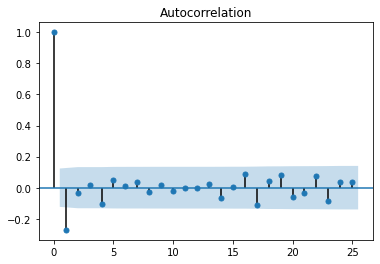

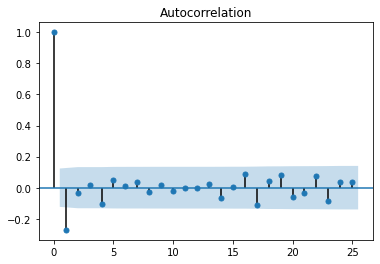

In [521]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train)

In [512]:
# from scipy.stats import t,norm
# sns.distplot(train,fit = t)
# 302/21.5
train

Series([], Name: log_return, dtype: float64)

In [824]:
from tqdm import tqdm
def arch_vol(ts):
    ts = ts.astype('double')
    model = arch_model(ts, mean='Constant', vol='ARCH', p=1,rescale = False)
    model_fit = model.fit(disp='off', show_warning=False)
    # forecast the test set
    yhat = model_fit.forecast(horizon=600)
    return np.sqrt(yhat.variance.values[-1, :].max())  
#     np.sqrt(ts.shape[0]-) return np.sqrt(yhat.variance.values[-1, :].sum())
def realized_volatility_per_time_id(file_path, prediction_column_name):
    df_book_data = pd.read_parquet(file_path)
    a = (df_book_data['bid_price1'] * df_book_data['ask_size1'] +
                                df_book_data['ask_price1'] * df_book_data['bid_size1']) / (
                                       df_book_data['bid_size1']+ df_book_data['ask_size1'])

    b = (df_book_data['bid_price2'] * df_book_data['ask_size2'] +
                                df_book_data['ask_price2'] * df_book_data['bid_size2']) / (
                                       df_book_data['bid_size2']+ df_book_data['ask_size2'])
    df_book_data['wap'] = (a+b)/2
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(arch_vol)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    stock_id = file_path.split('=')[1]
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    return df_realized_vol_per_stock[['row_id',prediction_column_name]]
def past_realized_volatility_per_stock(list_file,prediction_column_name):
    df_past_realized = pd.DataFrame()
    for file in tqdm(list_file):
        df_past_realized = pd.concat([df_past_realized,
                                     realized_volatility_per_time_id(file,prediction_column_name)])
    return df_past_realized

In [827]:
arch_vol((book_train_subset.loc[(book_train_subset.time_id == 16) ,'log_return' ]))
# book_train_subset.groupby(['time_id'])['log_return'].agg(arch_vol)

0.00017239582258430668

In [199]:
# np.sqrt(302)
train['row_id'] = train[['stock_id', 'time_id']].astype('str').agg('-'.join, axis=1)

In [393]:
df = train.merge(final_pred2,on = 'row_id')

In [203]:
rmspe

,target_x,target_y
target_x,1.0000,-0.0004
target_y,-0.0004,1.0000


In [55]:
# model_fit.variance
# (yhat.compute_variance)
# 16*np.sqrt(yhat.variance.values[-1, :].mean())
from arch.univariate import ConstantMean,GARCH, Normal
# from arch import 
ts = (book_train_subset.loc[(book_train_subset.time_id == 5) ,'log_return' ]).astype('double')

am = ConstantMean(ts)
am.volatility = GARCH(1, 0, 1)
am.distribution = Normal()
res = am.fit()
yhat = res.forecast(horizon=600)
# np.sqrt(sum(model_fit.conditional_volatility))
# yhat.variance.values[]

Iteration:      1,   Func. Count:      6,   Neg. LLF: -2073.6969189037263
Iteration:      2,   Func. Count:     22,   Neg. LLF: -2073.855263911387
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -2073.855263723061
            Iterations: 2
            Function evaluations: 22
            Gradient evaluations: 2


C:\Users\amakr\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.698e-08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e+04 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\amakr\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


In [385]:
list(set(book_train_subset.time_id.unique().tolist())-set(( book_train_subset.loc[book_train_subset['seconds_in_bucket']>=540].groupby(['time_id']).apply(len)).index.tolist()))

[13484, 22079]

In [389]:
(book_train_subset.groupby(['time_id'])

True

In [ ]:
# import seaborn as sns 
# import matplotlib.pyplot as plt
# plt.plot(book_train_subset.loc[book_train_subset.time_id == 72, 'bas'])
# book_train_subset.time_id.unique()[1:8]
# (book_train_subset['log_return']).mean()

In [ ]:
#keep_stock_id = 1
keep_stock_id = 0


In [ ]:
# dt.fread('../input/mytrain/X_stock_id_cat.csv').to_pandas()

In [ ]:
# train -------------------------
if keep_stock_id:
    td = dt.fread('../input/mytrain/X_stock_id_cat.csv')
    X = td.to_pandas()
    del td
else: 
    X = pd.read_csv("../input/mytrain/X.csv")
y = pd.read_csv("../input/mytrain/y.csv")
# to_test ----------------------------------------------------
test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
test_stock_stat_df = get_dataSet(stock_ids = test['stock_id'].unique(), dataType = 'test')
test_dataSet = pd.merge(test, test_stock_stat_df, on = ['stock_id', 'time_id'], how = 'left')
test_dataSet = test_dataSet
final_pred1 = test_dataSet[['row_id']]
to_test = test_dataSet.drop(['row_id'], axis = 1).fillna(0)
if keep_stock_id:
    train = pd.read_csv("../input/optiver-realized-volatility-prediction/train.csv")
    cols = [f'stock_id_{c}' for c in list(set(train.stock_id))]
    to_test[cols] = pd.DataFrame(np.stack([(to_test.stock_id == c).astype('int') for c in list(set(train.stock_id))]).T, columns = cols)
    to_test = to_test.drop("stock_id", axis = 1)
# else:
#     to_test = to_test.drop("stock_id", axis = 1)
#     X = X.drop("stock_id", axis = 1)

# Load in models

In [ ]:
output = []
if keep_stock_id:
    for filepath in glob.iglob('../input/629rvp-train/*.pkl'):
        model = joblib.load(filepath)
        y_pred = model.predict(to_test, num_iteration = model.best_iteration_)
        output.append(y_pred)
        del model
        del y_pred
else:
    for filepath in glob.iglob('../input/629rvpstock-id-as-continous/*.pkl'):
        model = joblib.load(filepath)
        y_pred = model.predict(to_test, num_iteration = model.best_iteration_)
        output.append(y_pred)
        del model
        del y_pred
y_pred = sum(output) / len(output)

In [ ]:
final_pred1 = final_pred1.assign(target = y_pred)

In [ ]:
realized_volatility_per_time_id()

# final_pred2
train = pd.read_csv('../data/train.csv')
train[]

# Best Naive baseline 0.29082
# Reference: https://www.kaggle.com/pratibha9/a-quick-model

In [390]:
def realized_volatility_per_time_id(file_path, prediction_column_name):
    df_book_data = pd.read_parquet(file_path)
    a = (df_book_data['bid_price1'] * df_book_data['ask_size1'] +
                                df_book_data['ask_price1'] * df_book_data['bid_size1']) / (
                                       df_book_data['bid_size1']+ df_book_data['ask_size1'])

    b = (df_book_data['bid_price2'] * df_book_data['ask_size2'] +
                                df_book_data['ask_price2'] * df_book_data['bid_size2']) / (
                                       df_book_data['bid_size2']+ df_book_data['ask_size2'])
    df_book_data['wap'] = (a+b)/2
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    stock_id = file_path.split('=')[1]
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    df_realized_vol_per_stock['len'] = df_book_data.groupby(['time_id']).apply(len).values
#     a = df_book_data.loc[df_book_data['seconds_in_bucket']>=540].groupby(['time_id']).apply(len)
#     a= pd.DataFrame({'time_id':a.index,'len_last_min': a.values})
#     df_realized_vol_per_stock= pd.merge(df_realized_vol_per_stock,a, on = 'time_id') 
    df_realized_vol_per_stock['len_last_min'] = df_book_data.groupby(['time_id']).apply(lambda x: x[x['seconds_in_bucket']>=540].shape[0] ).values

    df_realized_vol_per_stock['len_last_5'] = df_book_data.groupby(['time_id']).apply(lambda x: x[x['seconds_in_bucket']>=300].shape[0] ).values
    return df_realized_vol_per_stock[['row_id',prediction_column_name,'len','len_last_min','len_last_5']]
def past_realized_volatility_per_stock(list_file,prediction_column_name):
    df_past_realized = pd.DataFrame()
    for file in tqdm(list_file):
        df_past_realized = pd.concat([df_past_realized,
                                     realized_volatility_per_time_id(file,prediction_column_name)])
    return df_past_realized

In [370]:
# def get_len(file_path):
#     df_book_data = pd.read_parquet(file_path)
#     return ( df_book_data.loc[df_book_data['seconds_in_bucket']>=540].groupby(['time_id']).apply(len))
# pd.DataFrame(get_len(list_order_book_file_train[0]),columns= ['len_last_min']).merge

In [391]:
list_order_book_file_train = glob.glob('../data/book_train.parquet/*')
final_pred3 = past_realized_volatility_per_stock(list_file=list_order_book_file_train,
                                                           prediction_column_name='target')
# final_pred2

100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [14:23<00:00,  7.71s/it]


In [392]:
# realized_volatility_per_time_id(list_order_book_file_train[0],'target')
final_pred3

,row_id,target,len,len_last_min,len_last_5
0,0-5,0.004115,301,28,139
1,0-11,0.001268,199,22,115
2,0-16,0.002719,187,8,68
3,0-31,0.002625,119,7,53
4,0-62,0.001901,175,11,89
...,...,...,...,...,...
3825,99-32751,0.001555,488,58,265
3826,99-32753,0.001774,369,33,179
3827,99-32758,0.001583,501,49,239
3828,99-32763,0.002299,505,52,255


In [296]:
# train
np.log(df[['target_x','len']]).corr()

,target_x,len
target_x,1.000000,-0.066996
len,-0.066996,1.000000


In [284]:
final_pred3.to_csv('preds_naive.csv',index = False)

In [394]:
df = df.merge(final_pred3,on = 'row_id')
# df['tes'] = df['target_y']*np.sqrt(df['len'])

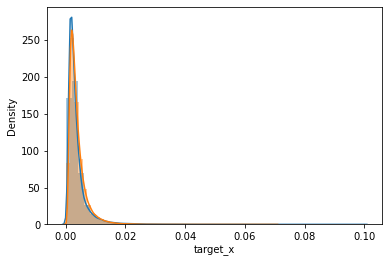

In [542]:
# np.log(df[['target_x','target','len','len_last_min','len_last_5']]+1).corr()
# df.groupby('stock_id').get_group(1)[['target_x','target','len','len_last_min','len_last_5']].corr()
# plt.scatter(df.target_x,df.target_y)
sns.distplot(df2.target)
sns.distplot(df.target_x)

In [592]:
# final_pred2.to_csv('preds_arch.csv',index = False)
# final_pred2.target.clip(upper = 0.1)
df2 = final_pred2.copy()
df2['target'].values[df2['target'] > 0.009] = 0.0031


In [593]:
# sns.distplot(df2.target)
rmse(df['target_x'],df2['target'])


0.5790718181538687

In [621]:
# np.corrcoef(df['target_x'],df2['target'])
df.target_x

0         0.004136
1         0.001445
2         0.002168
3         0.002195
4         0.001747
            ...   
428927    0.003461
428928    0.003113
428929    0.004070
428930    0.003357
428931    0.002090
Name: target_x, Length: 428932, dtype: float64

In [622]:
df

,stock_id,time_id,target_x,row_id,target_y,target,len,len_last_min,len_last_5
0,0,5,0.004136,0-5,0.003793,0.004115,301,28,139
1,0,11,0.001445,0-11,0.001438,0.001268,199,22,115
2,0,16,0.002168,0-16,0.003178,0.002719,187,8,68
3,0,31,0.002195,0-31,0.003836,0.002625,119,7,53
4,0,62,0.001747,0-62,0.002299,0.001901,175,11,89
...,...,...,...,...,...,...,...,...,...
428927,126,32751,0.003461,126-32751,0.003037,0.003338,309,32,142
428928,126,32753,0.003113,126-32753,0.003578,0.003347,222,32,105
428929,126,32758,0.004070,126-32758,0.003701,0.003695,255,32,167
428930,126,32763,0.003357,126-32763,0.002707,0.003375,398,37,191


In [204]:
def rmse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss


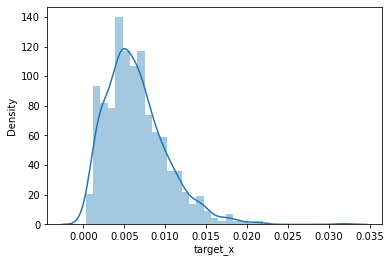

In [554]:
# df2
# np.exp(np.log(df['target_x']).mean())
sns.distplot(df[df.target_y>0.1]['target_x'])

In [567]:
rmse(df[df.target_y<0.1]['target_x'],df[df.target_y<0.1]['target_y'])
# df[df.target_y<0.01].shape[0]/df.shape[0]
# df['sqrt_len']=np.sqrt(df['len'])
# df.groupby(['stock_id']).get_group(0)[['target_x','len','target']].corr()

0.8308062139691802

In [260]:
(df[['target_x','len','target']]).corr()

,target_x,len,target
target_x,1.000000,-0.288174,0.866859
len,-0.288174,1.000000,-0.231883
target,0.866859,-0.231883,1.000000


In [92]:
#
final_pred2['time_id'] = final_pred2['row_id'].apply(lambda x : x.split('-')[1])
final_pred2['stock_id'] = final_pred2['row_id'].apply(lambda x : x.split('-')[0])

final_pred2

,row_id,target,time_id,stock_id
0,0-5,0.004115,5,0
1,0-11,0.001268,11,0
2,0-16,0.002719,16,0
3,0-31,0.002625,31,0
4,0-62,0.001901,62,0
...,...,...,...,...
3825,99-32751,0.001555,32751,99
3826,99-32753,0.001774,32753,99
3827,99-32758,0.001583,32758,99
3828,99-32763,0.002299,32763,99


In [ ]:
output = final_pred1.merge(final_pred2, on = "row_id", how = "outer").fillna(0)
# x: my pred, y: naive
my_pred_weight = 0.5
output["target"] = output.target_x * my_pred_weight + output.target_y * (1 - my_pred_weight)
output = output[["row_id", "target"]]
output.to_csv('submission.csv',index = False)
print(output)

In [ ]:
# get_stock_stat(0)
# plt.plot((book_train_subset.time_id.unique()))
# plt.plot(np.log(book_train_subset['wap']))

In [15]:
train = pd.read_csv('../data/train.csv')

In [22]:
tr = train.loc[train.stock_id == 0][['time_id','target']]
import matplotlib.pyplot as plt

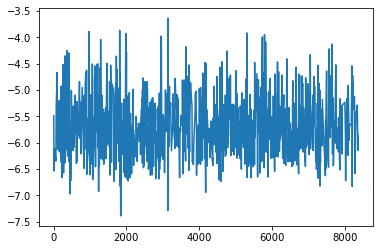

In [30]:
plt.plot((tr.time_id[:1000]), np.log(tr.target[:1000]))

C:\Users\amakr\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


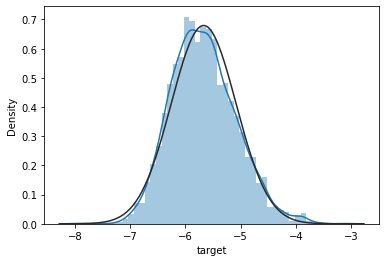

In [78]:
from scipy.stats import norm
tr = train.loc[train.stock_id == 16][['time_id','target']]
sns.distplot(np.log(tr.target),fit = norm)

In [57]:
def normality_test(data):
    from scipy.stats import normaltest
    mu, std = norm.fit(data)
    stat, p = normaltest((data-mu)/std)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [67]:
tr = train.loc[train.stock_id == 6][['time_id','target']]
normality_test(np.log(tr.target))
# mu, std = norm.fit(np.log(tr.target))
# mu, std

Statistics=9.444, p=0.009
Sample does not look Gaussian (reject H0)


(112,)

In [98]:
final_pred2.sort_values(['stock_id', 'time_id'], ascending = (True,True))

,row_id,target,time_id,stock_id
103,0-1000,0.002205,1000,0
1185,0-10000,0.002476,10000,0
1186,0-10005,0.008702,10005,0
1187,0-10017,0.011859,10017,0
1188,0-10030,0.002571,10030,0
...,...,...,...,...
1180,99-9972,0.001711,9972,99
1181,99-9973,0.010117,9973,99
1182,99-9976,0.004754,9976,99
1183,99-9988,0.001345,9988,99


In [596]:
df2.target == 

0       0.003793
1       0.001438
2       0.003178
3       0.003836
4       0.002299
          ...   
3825    0.001126
3826    0.001478
3827    0.001129
3828    0.001637
3829    0.000905
Name: target, Length: 428932, dtype: float32

In [544]:
# final_pred3.to_csv('with_len.csv')
from sklearn.linear_model import LinearRegression
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3
reg = LinearRegression().fit(X, y)
reg.score(X, y)

reg.coef_

reg.intercept_

reg.predict(np.array([[3, 5]]))

In [617]:
# df2.merge(df,on = 'row_id')
df

,stock_id,time_id,target_x,row_id,target_y,target,len,len_last_min,len_last_5
0,0,5,0.004136,0-5,0.003793,0.004115,301,28,139
1,0,11,0.001445,0-11,0.001438,0.001268,199,22,115
2,0,16,0.002168,0-16,0.003178,0.002719,187,8,68
3,0,31,0.002195,0-31,0.003836,0.002625,119,7,53
4,0,62,0.001747,0-62,0.002299,0.001901,175,11,89
...,...,...,...,...,...,...,...,...,...
428927,126,32751,0.003461,126-32751,0.003037,0.003338,309,32,142
428928,126,32753,0.003113,126-32753,0.003578,0.003347,222,32,105
428929,126,32758,0.004070,126-32758,0.003701,0.003695,255,32,167
428930,126,32763,0.003357,126-32763,0.002707,0.003375,398,37,191


In [627]:
# df.to_csv('train_2.csv',index = False)
ind_0 = df.groupby('stock_id').get_group(0)['target'].sort_values(ascending = False).index
val_0 = df.groupby('stock_id').get_group(0)['target'].sort_values(ascending = False).values

In [636]:
# plt.plot(val_0)


In [666]:
# tes['id'] = tes.index
# tes.columns
df.groupby('stock_id').get_group(0)

,stock_id,time_id,target_x,row_id,target_y,target,len,len_last_min,len_last_5
0,0,5,0.004136,0-5,0.003793,0.004115,301,28,139
1,0,11,0.001445,0-11,0.001438,0.001268,199,22,115
2,0,16,0.002168,0-16,0.003178,0.002719,187,8,68
3,0,31,0.002195,0-31,0.003836,0.002625,119,7,53
4,0,62,0.001747,0-62,0.002299,0.001901,175,11,89
...,...,...,...,...,...,...,...,...,...
3825,0,32751,0.002611,0-32751,0.002298,0.002474,296,24,150
3826,0,32753,0.001190,0-32753,0.002061,0.001845,205,22,100
3827,0,32758,0.004264,0-32758,0.002710,0.002320,187,27,104
3828,0,32763,0.004352,0-32763,0.002835,0.003100,306,35,163


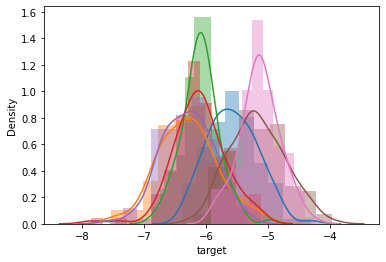

In [759]:
# df.loc[df.time_id == 5][['stock_id','target']]
# plt.scatter(df.loc[df.time_id == time_id]['stock_id'],df.loc[df.time_id == time]['target'],c= df.loc[df.time_id == 5]['target_x'] )
sns.distplot(np.log(df.loc[df.time_id == 5]['target']))
sns.distplot(np.log(df.loc[df.time_id == 11]['target']))
sns.distplot(np.log(df.loc[df.time_id == 16]['target']))
sns.distplot(np.log(df.loc[df.time_id == 31]['target']))
sns.distplot(np.log(df.loc[df.time_id == 62]['target']))
sns.distplot(np.log(df.loc[df.time_id == 72]['target']))
sns.distplot(np.log(df.loc[df.time_id == 97]['target']))



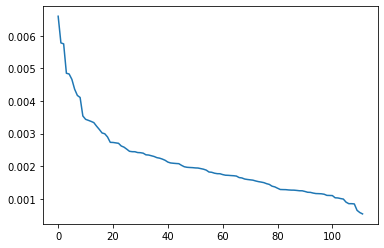

In [768]:
# df.time_id.unique().tolist()
# sns.distplot(np.log(df.target))
# plt.plot(df.target.sort_values(ascending = False).values)
# plt.plot(df.loc[df.time_id == 11].target.sort_values(ascending = False).values)


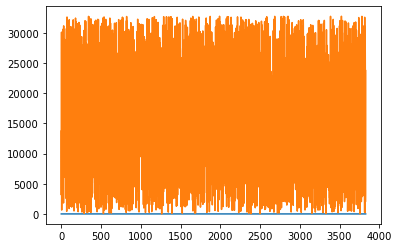

In [660]:
tes = df.groupby('stock_id').get_group(1)
tes = tes[['time_id', 'target_x', 'target_y', 'target',
       'len', 'len_last_min', 'len_last_5']].sort_values(by= 'target',ascending = False)
plt.plot(tes.reset_index()['target'])
# plt.plot(tes.reset_index()['len']/54000)
plt.plot(tes.reset_index()['time_id'])


In [806]:
# tes.corr()['target_x']
def alpha_estimator2(alpha,T,X):
    """
        Estimate Alpha parameter for  pareto stochastic process this method require X to be defined 
    """
    C=np.zeros(X.shape)
    n = len(X)
    for i in range(1,n):
        C[i]=np.log(X[i]/X[i-1])+((alpha[0])*np.log((T[i]+alpha[1])/(T[i-1]+alpha[1])))
    out1=0
    for i in range(1,n):
        out1=out1+((C[i])**2)
    return out1

In [814]:
alpha = [-1.2, 0]
b= a[a>0].reset_index(drop = True)
T = np.array(range(1,len(b)+1))
alpha_estimator2(alpha,T,(np.sqrt((b**2).cumsum())))
# b

7.437953012863379

[]

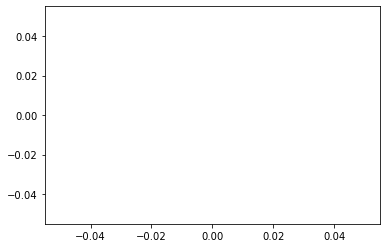

In [815]:
plt.plot()
